# Introducción a inferencia

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://static.thenounproject.com/png/542457-200.png" width="300px" height="300px" />

> Hasta ahora hemos hablado de la representación y propiedades básicas de las Redes Bayesianas, y como a través de su estructura podemos codificar ciertas independencias.
>
> En esta serie de clases operacionalizaremos las redes Bayesianas y estudiaremos como usar dichas representaciones (modelos) para responder preguntas que podrían surgir de la situación que estamos modelando.

> **Objetivos:**
> - Entender los diferentes tipos de preguntas que le podemos hacer a un modelo gráfico.

> **Referencias:**
> - Probabilistic Graphical Models: Principles and Techniques, By Daphne Koller and Nir Friedman. Ch. 9.
> - Pattern Recognition and Machine Learning, by Christopher M. Bishop - Cap. 8.
> - Bayesian Reasoning and Machine Learning by David Barber. Cap. 5.


<p style="text-align:right;"> Imagen recuperada de: https://static.thenounproject.com/png/542457-200.png.</p>

___

## 1. Introducción

En la clase anterior comenzamos nuestro estudio de redes Bayesianas, y vimos como las probabilidades (nuestras creencias) acerca de una variable cambian cuando incorporamos evidencia, de una manera intuitiva.

En esta secuencia, describiremos algunos algoritmos para calcular eficientemente estas probabilidades, cuando la evidencia cambia. Similarmente, veremos como usar algoritmos de inferencia para hacer predicciones de los valores de variables basados en nuestro modelo.

### 1.1. Probabilidades condicionales

Son el tipo de pregunta más común que le hacemos a un modelo probabilístico.

Dadas:

- Una distribución conjunta de probabilidad

  $$P(X_1,\dots, X_n),$$

  (modelada a través de una red Bayesiana);
  
- Un conjunto de variables de interés $\bar{Y}\subseteq \left\{X_1,\dots, X_n\right\}$;

- Un conjunto de variables observadas (evidencia) $\bar{E} = \bar{e}$, con $\bar{E}\subseteq \left\{X_1,\dots, X_n\right\}$,

Definimos $\bar{W} = \left\{X_1,\dots, X_n\right\} \setminus \left\{\bar{Y} \cup \bar{E}\right\}$ como el resto de variables.

**La tarea es calcular la probabilidad condicional:** $P(\bar{Y} | \bar{E}=\bar{e})$.

**Aplicaciones:**

- *Un modelo de riesgo crediticio*: se observan ciertas variables del cliente (flujo de capital, patrimonio, activos, pasivos, historial ...), y se estaría interesado en calcular la probabilidad de ciertas variables no obervables para el banco.

- *Un sistema de diagnóstico médico*: se observan ciertas variables (síntomas, resultados de exámenes) y estamos interesados en calcular la probabilidad de presencia de alguna enfermedad.

**¿Cómo?**

Por la definición de probabilidad condicional:

$$P(\bar{Y} | \bar{E}=\bar{e}) = \frac{P(\bar{Y}, \bar{e})}{P(\bar{e})}.$$

En esta expresión:

- $P(\bar{Y}, \bar{e}) = \sum_{\bar{W}} P(\bar{Y}, \bar{e}, \bar{W})$.

  Recordemos que $\left\{X_1,\dots, X_n\right\} = \bar{Y} \cup \bar{E} \cup \bar{W}$. Entonces, los términos en la suma del lado derecho son probabilidades conjuntas de todas las variables.
  
- $P(\bar{e}) = \sum_{\bar{Y}} P(\bar{Y}, \bar{e})$.

  Esta es simplemente una constante de normalización para convertir $P(\bar{Y}, \bar{e})$ into $P(\bar{Y} | \bar{e})$.

Entonces, en principio podríamos:

- Tomar una red Bayesiana;
- Multiplicar todas las probabilidades condicionales para obtener la distribución condicional;
- Marginalizar las variables no deseadas en la distribución conjunta;
- **¡Listo!**

**Ejemplo:** Restaurante

Variables:
- Ubicación $L$ (Bad: $l^0$, Good: $l^1$).
- Calidad $Q$ (Bad: $q^0$, Normal: $q^1$, Good: $q^2$).
- Costo $C$ (Low: $c^0$, High: $c^1$).
- Número de personas $N$ (Low: $n^0$, High: $n^1$).

In [3]:
from IPython.display import Image

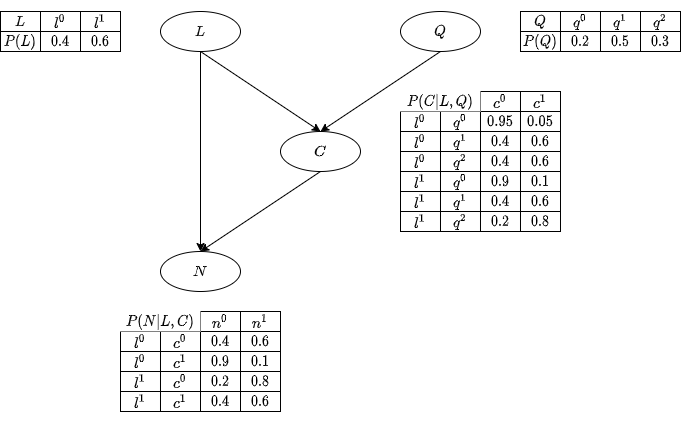

In [4]:
Image("figures/restaurant.png")

In [1]:
# Import pgmpy.factors.discrete.TabularCPD
from pgmpy.factors.discrete import TabularCPD

In [5]:
# Define factors
cpd_L = TabularCPD(
    variable="L",
    variable_card=2,
    values=[[0.4],
            [0.6]]
)
cpd_Q = TabularCPD(
    variable="Q",
    variable_card=3,
    values=[[0.2],
            [0.5],
            [0.3]]
)
cpd_C = TabularCPD(
    variable="C",
    variable_card=2,
    evidence=["L", "Q"],
    evidence_card=[2, 3],
    values=[[0.95, 0.4, 0.4, 0.9, 0.4, 0.2],
            [0.05, 0.6, 0.6, 0.1, 0.6, 0.8]]
)
cpd_N = TabularCPD(
    variable="N",
    variable_card=2,
    evidence=["L", "C"],
    evidence_card=[2, 2],
    values=[[0.4, 0.9, 0.2, 0.4],
            [0.6, 0.1, 0.8, 0.6]]
)

In [6]:
# Joint probability
joint = (cpd_L.to_factor() 
         * cpd_Q.to_factor() 
         * cpd_C.to_factor()
         * cpd_N.to_factor())
print(joint)

+------+------+------+------+----------------+
| L    | Q    | C    | N    |   phi(L,Q,C,N) |
+======+======+======+======+================+
| L(0) | Q(0) | C(0) | N(0) |         0.0304 |
+------+------+------+------+----------------+
| L(0) | Q(0) | C(0) | N(1) |         0.0456 |
+------+------+------+------+----------------+
| L(0) | Q(0) | C(1) | N(0) |         0.0036 |
+------+------+------+------+----------------+
| L(0) | Q(0) | C(1) | N(1) |         0.0004 |
+------+------+------+------+----------------+
| L(0) | Q(1) | C(0) | N(0) |         0.0320 |
+------+------+------+------+----------------+
| L(0) | Q(1) | C(0) | N(1) |         0.0480 |
+------+------+------+------+----------------+
| L(0) | Q(1) | C(1) | N(0) |         0.1080 |
+------+------+------+------+----------------+
| L(0) | Q(1) | C(1) | N(1) |         0.0120 |
+------+------+------+------+----------------+
| L(0) | Q(2) | C(0) | N(0) |         0.0192 |
+------+------+------+------+----------------+
| L(0) | Q(2)

In [7]:
# P(N)
p_N = joint.marginalize(variables=["L", "Q", "C"],
                        inplace=False)
print(p_N)

+------+----------+
| N    |   phi(N) |
+======+==========+
| N(0) |   0.4452 |
+------+----------+
| N(1) |   0.5548 |
+------+----------+


In [3]:
# Show


**¿Cuál es el problema?**

*El problema crece exponencialmente en complejidad computacional con el número de variables / cardinalidad*.

En efecto, el problema de inferencia en redes Bayesianas (tal como la mayoría de problemas interesantes en matemáticas) es $\mathcal{NP}-$hard. 

**¿Esto qué significa?**

- Si un problmea es $\mathcal{NP}-$hard es muy poco probable de que encontremos una solución general eficiente.

- Esto significa que **todos los algoritmos** que se han construido hasta hoy, requieren un tiempo (o número de operaciones básicas) exponencial en el tamaño de la representación del problema.

- Estos resultados son, claramente, un análisis del peor caso. Estudiaremos ciertos algoritmos (exactos y aproximados) que nos permitirán hacerlo mucho mejor que este peor caso.

### 1.2. Inferencia Máximo A-Posteriori (MAP)

Dadas:

- Una distribución conjunta de probabilidad

  $$P(X_1,\dots, X_n),$$

  (modelada a través de una red Bayesiana);
  
- Un conjunto de variables de interés $\bar{Y}\subseteq \left\{X_1,\dots, X_n\right\}$;

- Un conjunto de variables observadas (evidencia) $\bar{E} = \bar{e}$, con $\bar{E}\subseteq \left\{X_1,\dots, X_n\right\}$,

Supondremos en este caso, por simplicidad, que $\bar{Y}\cup \bar{E} = \left\{X_1,\dots, X_n\right\}$.

**La tarea es calcular:** 

$$MAP(\bar{Y} | \bar{E}=\bar{e}) = \arg\max_{\bar{y}\in\mathrm{Val}(\bar{Y})} P(\bar{Y} | \bar{E}=\bar{e}).$$

> ¡Podría haber múltiples soluciones!

**Aplicación:**

- Clasificador: una vez aprendemos una modelo a partir de datos / experiencia, podríamos querer calcular cuál es el valor más probable de ciertas variables, dada la observación de otras variables (evidencia).

**MAP $\neq$ Máx. sobre marginales:**

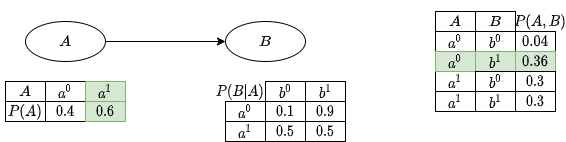

In [4]:
Image("figures/simple.png")

De nuevo, este problema es $\mathcal{NP}-$hard.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>